## Python translation from the programm of : https://github.com/tianhanguan/Markov_Chain_Monte_Carlo_methods

## Libraries set up

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

### Simulation of data following a GARCH(1,1) process

The following code is used to simulate a GARCH(1,1) model with N data points 

In [2]:
N = 2000  #Run size
n = 100  #Burn-in size
a = [0.8, 0.2, 0.5] # parameters of the GARCH model : omega, alpha, beta 

Generate the GARCH(1,1) process iteratively by its definition. A process $\r_{t}$ folows a Garch representation if :

$r_{t}=z_{t}*\sqrt{h_{t}}$,

$h_{t} = \omega + \alpha*r_{t-1}^2 + \beta*h_{t-1}$,

Where $z_{t}$ is a weak white noise,

And $\omega>0$, $\alpha>0$, $\beta>0$

GARCH, Generalized Autoregressive Conditional Heteroskedasticity, suppose volatility of time t affects volatility of t+1. The volatility is thus not constant. $h_t$ is thus the variance of $r_t$ knowing the volatility and the GARCH value of all the previous period. 

PS : We could have defined $y = c + r_{t}$ with c a constant

In [3]:
def garch_11(parameters, N):   #Size of the generated data
    r = np.zeros(N)  # r corresponds to the Garch process
    h = np.zeros(N)  # h corresponds to the volatility : h=sigma^2

    # We define the initial values of e and h 
    r[0] = 0.1
    h[0] = 0.01

    WN = np.random.normal(0, 1, N)  # noise follows a Normal(0,1)

    for i in range(1, N):
        h[i] = parameters[0] + parameters[1] * r[i-1]**2 + parameters[2] * h[i-1]
        r[i] = np.sqrt(h[i]) * WN[i]

    return r,h

Simulated true data of the previously defined GARCH(1,1) process

In [4]:
r_garch = garch_11(a, N)[0][(n + 1):N]

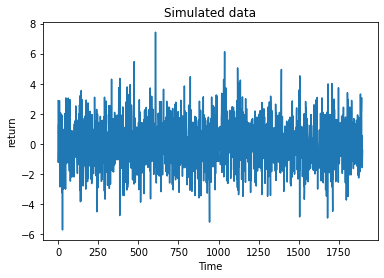

In [5]:
plt.plot(r_garch)
plt.title('Simulated data')
plt.xlabel('Time')
plt.ylabel('return')
plt.show()

In [6]:
h_garch = garch_11(a, N)[1][(n + 1):N]

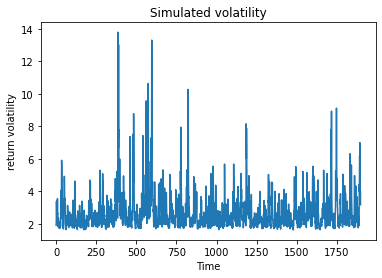

In [7]:
plt.plot(h_garch)
plt.title('Simulated volatility')
plt.xlabel('Time')
plt.ylabel('return volatility')
plt.show()

## MCMC

We define the density distribution of our target function "a une constante près" with a centered normal distribution for one point of the time series. $r_{t}|F_t$, the garch process, is indeed supposed to follow a normal law distribution $(0,h_{t})$. We define the log likelihood by iteration on simulated data to find the density of a combination of parameter on all the Garch process. 

It is important to fix the right initial h in the following function.

Function to iteratively calculate the logged posterior (what is the prior?) distribution :

In [8]:
def g0(r, h):
    return -0.5 * np.log(h) - 0.5 * (r**2 / h) # Why suppose a normal law?

def g(x):
    h = abs(r_garch[0]) # How to define h? Is it very important (test different h)?
    LL = g0(r_garch[0],h) # density is initialized with our first simulated data

    for i in range(1, len(r_garch)):
        h = x[0] + x[1] * r_garch[i-1]**2 + x[2] * h
        LL += g0(r_garch[i],h)

    return LL

We define the parameters that will be used in the algorithm :

In [9]:
M = 10000  # run length
B = 2000  # amount of burn-in

X = np.random.rand(3) # Random starting point for the Markov chain (dim=3)
# On devrait tester l'algo plusieurs fois en laissant X se réinitialiiser à chaque fois 
#X= [0.89640571, 0.62853914, 0.99766534]
sigma = 0.07  # volatility for the proposal function 
x1list = np.zeros(M)  # for keeping track of omega values
x2list = np.zeros(M)  # for keeping track of alpha values
x3list = np.zeros(M)  # for keeping track of beta values
numaccept = 0 #counts the number of acceptance in the accept/rejct algorithm

The goal is to draw more times a combination of the 3 parameters where the loglikelyhoood is large so that we can approximate precisely the expectation of the sample, ie the value of the parameters that match our data. We define a combination of 3 parameters X and a new combination Y from X based on a random draw in a centered normal law of volatility defined in advance. When the probability density, i.e. the likelihood, is higher for the combination Y than for the combination X, we accept, because we are heading towards a location where the density is higher. So Y corresponds probably more tp the parameter combination that fits our data than the X combination was. If the probability density for the combination Y is lower than the probability density for the combination X then we accept only if their ratio (thus lower than 1) is higher than U, drawing a uniform law between 0 and 1. Moreover we reject directly if at least one of the 3 parameters of Y is negative.

Warning : we apply log to density, so it is not a ratio but a difference.

By repeating this algorithm a certain number of times we will get more combinations that fit our data. We can also restart the algorithm from the beginning, thus with a new initial X, a certain number of times, to better approximate the parameter combination.

Algorythm :

In [10]:
for i in range(M):
    Y = X + np.random.normal(loc = 0, scale = sigma, size=3)  # Proposal move with a normal distribution (dim=3 because 3 parameters)
    U = np.log(np.random.rand(1)) # Random draw in a uniform distribution for accept/reject
    if np.all(Y > 0):
        alpha = g(Y) - g(X)  # Difference between current and previous density accept/reject
        if U < alpha:  # Reject all samples where any parameter is negative
            X = Y  # Accept proposal
            numaccept += 1 # Counts the number of acceptance in the accept/rejct algorithm
    
    x1list[i] = X[0]   # for keeping track of omega values
    x2list[i] = X[1]   # for keeping track of alpha values
    x3list[i] = X[2]   # for keeping track of beta values
    
    # Output progress report (can be long)
    if (i % 1000) == 0:
        print(" ...", i)

 ... 0
 ... 1000
 ... 2000
 ... 3000
 ... 4000
 ... 5000
 ... 6000
 ... 7000
 ... 8000
 ... 9000


In [11]:
print("ran Metropolis algorithm for", M, "iterations, with burn-in", B)
print("acceptance rate =", numaccept/M)
u = np.mean(x1list[(B+1):M])
print("mean of x1 is about", u)
v = np.mean(x2list[(B+1):M])
print("mean of x2 is about", v)
w = np.mean(x3list[(B+1):M])
print("mean of x3 is about", w)

ran Metropolis algorithm for 10000 iterations, with burn-in 2000
acceptance rate = 0.1536
mean of x1 is about 1.104402169989103
mean of x2 is about 0.20033694353307485
mean of x3 is about 0.3441988447425245


In [12]:
def varfact(x):
    acf_vals = acf(x, nlags=None, fft=True)  # Calculer l'ACF
    var_factor = 2 * np.sum(acf_vals) - 1  # Calculer le facteur de variance
    return var_factor

In [13]:
# Calculer les écarts-types des listes x1list, x2list et x3list
se11 = np.std(x1list[(B+1):M]) / np.sqrt(M-B)
se12 = np.std(x2list[(B+1):M]) / np.sqrt(M-B)
se13 = np.std(x3list[(B+1):M]) / np.sqrt(M-B)

# Calculer les facteurs de variance des listes x1list, x2list et x3list
thevarfact1 = varfact(x1list[(B+1):M])
thevarfact2 = varfact(x2list[(B+1):M])
thevarfact3 = varfact(x3list[(B+1):M])

# Calculer les erreurs standards véritables (true standard errors) et les intervalles de confiance approximatifs à 95%
se1 = se11 * np.sqrt(thevarfact1)
se2 = se12 * np.sqrt(thevarfact2)
se3 = se13 * np.sqrt(thevarfact3)

# Afficher les résultats
print("true standard error of omega is about", se1)
print("approximate 95% confidence interval of omega is (", u - 1.96 * se1, ",", u + 1.96 * se1, ")\n")

print("true standard error of alpha is about", se2)
print("approximate 95% confidence interval of alpha is (", v - 1.96 * se2, ",", v + 1.96 * se2, ")\n")

print("true standard error of beta is about", se3)
print("approximate 95% confidence interval of beta is (", w - 1.96 * se3, ",", w + 1.96 * se3, ")\n")

true standard error of omega is about 0.0235398611786586
approximate 95% confidence interval of omega is ( 1.058264042078932 , 1.1505402978992738 )

true standard error of alpha is about 0.0016008669660303662
approximate 95% confidence interval of alpha is ( 0.19719924427965532 , 0.20347464278649438 )

true standard error of beta is about 0.010558734424292653
approximate 95% confidence interval of beta is ( 0.32350372527091087 , 0.3648939642141381 )



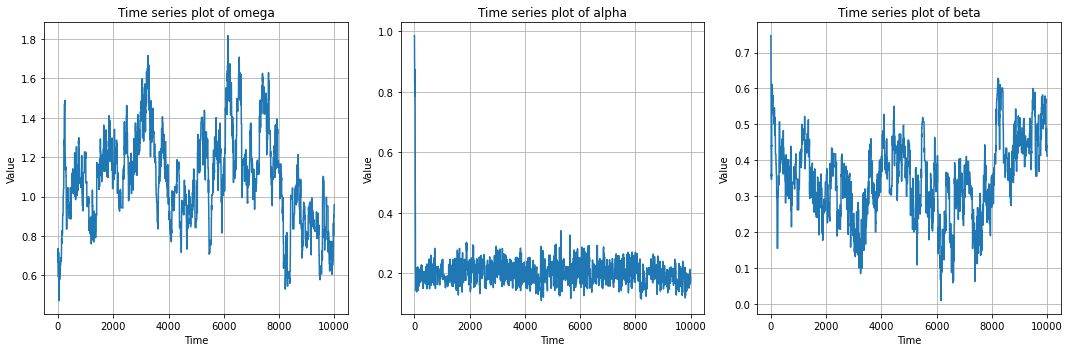

In [14]:
# Créer une figure avec une grille de 1 ligne et 3 colonnes
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Tracer les graphiques de séries temporelles pour x1list, x2list et x3list
axs[0].plot(x1list)
axs[0].set_title("Time series plot of omega")
axs[1].plot(x2list)
axs[1].set_title("Time series plot of alpha")
axs[2].plot(x3list)
axs[2].set_title("Time series plot of beta")

# Réglages des titres et de la grille pour les graphiques de séries temporelles
for ax in axs:
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")
    ax.grid(True)

# Afficher les graphiques de séries temporelles côte à côte
plt.tight_layout()
plt.show()

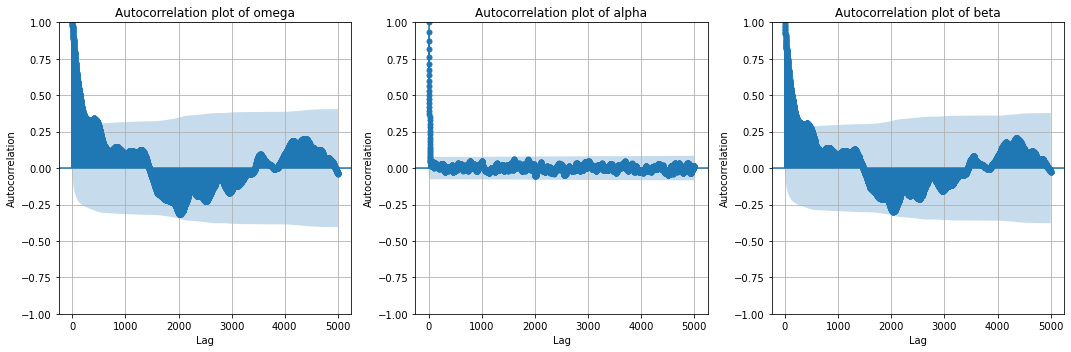

In [15]:
# Créer une nouvelle figure avec une grille de 1 ligne et 3 colonnes
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Tracer les graphiques d'autocorrélation pour x1list, x2list et x3list
plot_acf(x1list, ax=axs[0], lags=5000)
axs[0].set_title("Autocorrelation plot of omega")
plot_acf(x2list, ax=axs[1], lags=5000)
axs[1].set_title("Autocorrelation plot of alpha")
plot_acf(x3list, ax=axs[2], lags=5000)
axs[2].set_title("Autocorrelation plot of beta")

# Réglages des titres et de la grille pour les graphiques d'autocorrélation
for ax in axs:
    ax.set_xlabel("Lag")
    ax.set_ylabel("Autocorrelation")
    ax.grid(True)

# Afficher les graphiques d'autocorrélation côte à côte
plt.tight_layout()
plt.show()

Code pour répéter plusieur fois l'algorythme